In [1]:
import numpy as np
import pandas as pd
import h5py

import scipy
from sklearn.linear_model import LinearRegression
import tfbio.data
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
sns.set(context='paper', style='white')
sns.set_color_codes()

%matplotlib inline

/home2/kanakala.ganesh/miniconda3/envs/pafnucy_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home2/kanakala.ganesh/miniconda3/envs/pafnucy_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home2/kanakala.ganesh/miniconda3/envs/pafnucy_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

# Data and parameters

In [2]:
# directories with input (pdbbind), results and plots, and training stats

pdbbind_path = '../pdbbind/v2016'
results_path = './results'
results_prefix = '%s/batch5-2017-06-05T07:58:47' % results_path

In [3]:
# network parameters
featurizer = tfbio.data.Featurizer()
max_dist = 10
box_size = 21
columns = {name: i for i, name in enumerate(featurizer.FEATURE_NAMES)}
num_features = len(columns)

# scaling factor for partial charges
charge_std = 0.425896

In [4]:
# colors for subsets

set_colors = {

    # PDBbind v. 2016 split
    'core': 'r',
    'refined': 'g',
    'general': 'b',
    
    # our split
    'training': 'b',
    'validation': 'g',
    'test': 'r',
    'core2013': 'purple'
}

set_titles = {
    'training': 'training set',
    'validation': 'validation set',
    'test': 'core set v. 2016',
    'core2013': 'core set v. 2013'
}

In [5]:
protein_data = pd.read_csv('protein_data.csv')
protein_data.head()

,pdbid,year,uniprotid,name
0,3eql,2008,Q9Z9H6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
1,1zyr,2005,Q5SHR6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
2,3dxj,2008,Q5SHR6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
3,4zh4,2015,P0A7Z4,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
4,4zh3,2015,P0A7Z4,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA


In [6]:
affinity_data = pd.read_csv('affinity_data_cleaned.csv')
affinity_data = affinity_data.rename(columns={'set': 'pdbbind_set'})
affinity_data.head()

,pdbid,-logKd/Ki,pdbbind_set
0,3zzf,0.40,general
1,3gww,0.45,general
2,1w8l,0.49,general
3,3fqa,0.49,general
4,1zsb,0.60,general


In [7]:
dataset_split = []

for set_name in ['training', 'validation', 'test']:
    with h5py.File('%s/%s_set.hdf' % (pdbbind_path, set_name), 'r') as f:
        dataset_split.append(pd.DataFrame({'set': set_name, 'pdbid': list(f.keys())}))

dataset_split = pd.concat(dataset_split, ignore_index=True)
dataset_split.head()

,pdbid,set
0,11gs,training
1,13gs,training
2,16pk,training
3,184l,training
4,185l,training


In [8]:
affinity_data = pd.merge(affinity_data, dataset_split)
affinity_data.head()

,pdbid,-logKd/Ki,pdbbind_set,set
0,3zzf,0.40,general,training
1,3gww,0.45,general,training
2,1w8l,0.49,general,training
3,3fqa,0.49,general,training
4,1zsb,0.60,general,training


In [9]:
affinity_data['set'].value_counts()

training      11906
validation     1000
test            290
Name: set, dtype: int64

In [10]:
# training logs downloaded from tensorboard

training_mse = pd.read_csv('%s-training_set_mse_all.csv' % results_prefix)
validation_mse = pd.read_csv('%s-validation_set_mse_all.csv' % results_prefix)

# Create the network

In [11]:
graph = tf.Graph()

with graph.as_default():
    saver = tf.train.import_meta_graph('./%s-best.meta' % results_prefix,
                                       clear_devices=True)

In [12]:
# get tensors we need to get predictions and the error

x = graph.get_tensor_by_name('input/structure:0')
y = graph.get_tensor_by_name('output/prediction:0')
t = graph.get_tensor_by_name('input/affinity:0')
keep_prob = graph.get_tensor_by_name('fully_connected/keep_prob:0')

mse = graph.get_tensor_by_name('training/mse:0')

In [13]:
# get tensors we might need to analyze the network

# activations on hidden layers
hidden_layers = [
    graph.get_tensor_by_name('convolution/conv0/h_pool:0'),
    graph.get_tensor_by_name('convolution/conv1/h_pool:0'),
    graph.get_tensor_by_name('convolution/conv2/h_pool:0'),
    graph.get_tensor_by_name('fully_connected/fc0/h_dropout/mul:0'),
    graph.get_tensor_by_name('fully_connected/fc1/h_dropout/mul:0'),
    graph.get_tensor_by_name('fully_connected/fc2/h_dropout/mul:0')
]

# weights
weights = [
    graph.get_tensor_by_name('convolution/conv0/w:0'),
    graph.get_tensor_by_name('convolution/conv1/w:0'),
    graph.get_tensor_by_name('convolution/conv2/w:0'),
    graph.get_tensor_by_name('fully_connected/fc0/w:0'),
    graph.get_tensor_by_name('fully_connected/fc1/w:0'),
    graph.get_tensor_by_name('fully_connected/fc2/w:0'),
]

# Training progress

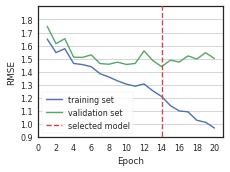

In [14]:
best_model = validation_mse[validation_mse['Value'] == validation_mse['Value'].min()]
best_epoch = best_model.index + 1
best_value = best_model['Value']


fig, ax = plt.subplots(figsize=(3.3, 2.5))

# plot rmse instead of mse
ax.plot(range(1, 21), training_mse['Value'] ** 0.5, label=set_titles['training'])
ax.plot(range(1, 21), validation_mse['Value'] ** 0.5, label=set_titles['validation'])

ax.vlines(best_epoch, 0, 2, color='r', linestyles='--', zorder=4, label='selected model')

ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

ax.set_xlim(0, 21)
ax.set_xticks(range(0, 21, 2))
ax.grid(True, axis='y')
ax.set_ylim(0.9, 1.9)
ax.set_yticks(np.arange(0.9, 1.9, 0.1))

ax.legend(frameon=True, loc='lower left')
fig.tight_layout()
fig.savefig('%s/rmse.pdf' % results_path);

# Predictions

## Predict on PDBbind v2013 core set

In [15]:
# load the data

affinity = []
coords = []
features = []
ids = []

with h5py.File('%s/core2013.hdf' % pdbbind_path, 'r') as f:
    for pdb_id in f:
        ids.append(pdb_id)
        dataset = f[pdb_id]
        coords.append(dataset[:, :3])
        features.append(dataset[:, 3:])

        affinity.append(dataset.attrs['affinity'])

affinity = np.reshape(affinity, (-1, 1))

In [16]:
# prepare grids

batch_grid = []

for crd, f in zip(coords, features):
    batch_grid.append(tfbio.data.make_grid(crd, f))

batch_grid = np.vstack(batch_grid)
batch_grid[..., columns['partialcharge']] /= charge_std

In [17]:
# restore the trained model and predict affinities

with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    pred_affinity = session.run(y, feed_dict={x: batch_grid, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


## Merge with predictions for v2016

The predictions for PDBbind v 2016 were already computed at the end of the training (see `train.py` script) and saved in &lt;prefix&gt;-predictions.csv file.

In [18]:
predictions = pd.concat(
    [
        pd.read_csv('%s-predictions.csv' % results_prefix),
        pd.DataFrame({'pdbid': ids, 'predicted': pred_affinity.flatten(),
                      'real': affinity.flatten(), 'set': 'core2013'})
    ]
)

predictions.head()

,pdbid,predicted,real,set
0,11gs,6.807291,5.82,training
1,13gs,5.665529,4.62,training
2,16pk,4.755159,5.22,training
3,184l,5.689533,4.72,training
4,185l,4.648183,3.54,training


  core2013 set: RMSE=1.623, MAE=1.318, R=0.70 (p=1.05e-29), SD=1.614
      test set: RMSE=1.423, MAE=1.136, R=0.77 (p=4.08e-59), SD=1.378
  training set: RMSE=1.214, MAE=0.954, R=0.77 (p=0.00e+00), SD=1.188
validation set: RMSE=1.440, MAE=1.138, R=0.72 (p=1.51e-159), SD=1.428


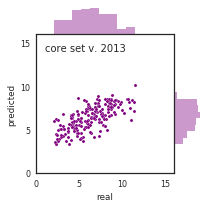

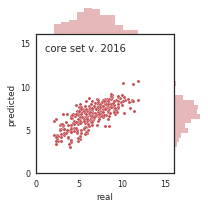

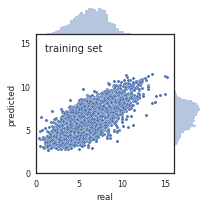

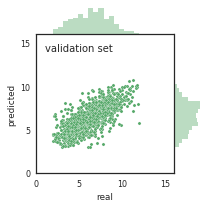

In [19]:
for set_name, table in predictions.groupby('set'):
    rmse = ((table['predicted'] - table['real']) ** 2).mean() ** 0.5
    mae = (np.abs(table['predicted'] - table['real'])).mean()
    corr = scipy.stats.pearsonr(table['predicted'], table['real'])
    lr = LinearRegression()
    lr.fit(table[['predicted']], table['real'])
    y_ = lr.predict(table[['predicted']])
    sd = (((table['real'] - y_) ** 2).sum() / (len(table) - 1)) ** 0.5
    print('%10s set: RMSE=%.3f, MAE=%.3f, R=%.2f (p=%.2e), SD=%.3f' % (set_name, rmse, mae, *corr, sd))

    grid = sns.jointplot('real', 'predicted', data=table, stat_func=None, color=set_colors[set_name],
                         space=0.0, size=3, s=10, edgecolor='w', ylim=(0, 16), xlim=(0, 16))

    grid.ax_joint.text(1, 14, set_titles[set_name])
    grid.ax_joint.set_xticks(range(0, 16, 5))
    grid.ax_joint.set_yticks(range(0, 16, 5))

    grid.fig.savefig('%s/pred_%s.pdf' % (results_path, set_name))

In [20]:
predictions.to_csv('%s-all_predictions.csv' % results_prefix, index=False)

# Select examples

Get protein with the biggest number of complexes in the v2016 core set (which was used as test set)

In [21]:
core_pdbids = list(affinity_data[affinity_data['pdbbind_set'] == 'core']['pdbid'])

core_idx = np.in1d(protein_data['pdbid'], core_pdbids)

num_complexes = (protein_data
                 .loc[core_idx]
                 .groupby('uniprotid')
                 ['name']
                 .agg(len)
                 .sort_values(ascending=False))

num_complexes[:10]

uniprotid
Q9Y233    10
P00918     5
P18031     5
P11838     5
Q9L5C8     5
P0A5R0     5
P0A4Z6     5
P07900     5
P04637     5
P04058     5
Name: name, dtype: int64

In [22]:
unid = num_complexes.index[0]
unid

'Q9Y233'

In [23]:
complexes = protein_data.loc[(protein_data['uniprotid'] == unid), 'pdbid']
examples = affinity_data.loc[np.in1d(affinity_data['pdbid'], complexes),
                             ['pdbid', 'pdbbind_set', 'set']]
examples = examples.reset_index(drop=True)
num_examples = len(examples)
print(num_examples, 'examples')
examples.head()

57 examples


,pdbid,pdbbind_set,set
0,4llx,core,test
1,4lm3,refined,validation
2,4llk,refined,training
3,4lm2,refined,validation
4,4lm4,refined,training


In [24]:
# load the input and affinities for selected examples

affinity = []
coords = []
features = []
ids = []


for set_name, table in examples.groupby('set'):
    with h5py.File('%s/%s_set.hdf' % (pdbbind_path, set_name), 'r') as f:
        for pdb_id in table['pdbid']:
            ids.append(pdb_id)
            dataset = f[pdb_id]
            coords.append(dataset[:, :3])
            features.append(dataset[:, 3:])
            
            affinity.append(dataset.attrs['affinity'])

affinity = np.reshape(affinity, (-1, 1))            

# Results for different orientation of the input

Let's check whether we get similar results for differently presented input.
Our model is not invariant to input orientation.
Each complex was centered at ligand's geometric center, so we do not need to worry about translations.
However our model might be sensitive to input rotation.

We will predict affinity for 24 orientations of a molecular complex and check if they are stable.

In [25]:
rot_predictions = []

with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)
    
    for rotation in range(24): 
        print(rotation)
        batch_grid = np.zeros((num_examples, box_size, box_size, box_size, num_features))
        
        for i, (crds, ft) in enumerate(zip(coords, features)):
            crds = tfbio.data.rotate(crds, rotation)
            batch_grid[i] = tfbio.data.make_grid(crds, ft)
        batch_grid[..., columns['partialcharge']] /= charge_std
        

        pred_affinity = session.run(y, feed_dict={x: batch_grid,
                                                  t: np.reshape(affinity, (num_examples, 1)),
                                                  keep_prob: 1.0})
        rot_predictions.append(pd.DataFrame({'rotation': rotation, 'pdbid': ids,
                                             'predicted': np.squeeze(pred_affinity)}))

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [26]:
rot_predictions = pd.concat(rot_predictions)
rot_predictions = pd.merge(rot_predictions, affinity_data)
rot_predictions = rot_predictions.sort_values('predicted')

In [27]:
rot_predictions['pdbid'] = rot_predictions['pdbid'].str.upper()

In [28]:
palette = {}
for set_name, idx in rot_predictions.groupby('set')['pdbid'].agg(lambda x: set(x)).items():
    for i in idx:
        palette[i] = set_colors[set_name]

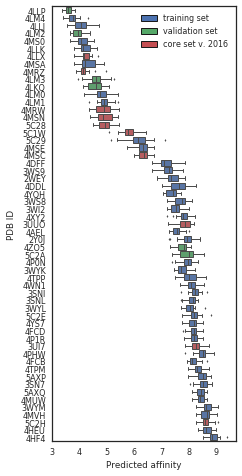

In [29]:
# plot range of predicted affinities for each complex
# sort by predicted value and color by training/validation/test split

fig, ax = plt.subplots(figsize=(3.3, 8))
sns.boxplot(y='pdbid', x='predicted', data=rot_predictions, ax=ax, palette=palette, linewidth=1, fliersize=2)

ax.set_xlim(3,)
ax.set_xlabel('Predicted affinity')
ax.set_ylabel('PDB ID')

# we need to manually add the legend
handles = []
labels = []
for set_name in ['training', 'validation', 'test']:
    handles.append(Rectangle((0, 0), 1, 1, fc=set_colors[set_name], lw=1, ec='k'))
    labels.append(set_titles[set_name])
ax.legend(handles, labels, loc='upper right')

fig.savefig('%s/rotations.pdf' % results_path, bbox_inches='tight');

#  Network properties

## Feature importance

Check distribution of weights for each of the feautures.
The higher the absolute value of the weight, the more information comes out of this part of an input.

In [30]:
# get outgoing weights for each feature

with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)
    w0 = session.run(weights[0])  

w0 = pd.DataFrame(np.transpose(w0, [0, 1, 2, 4, 3]).reshape((-1, num_features)),
                  columns=featurizer.FEATURE_NAMES)

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


Check how much the distribution of weights for each feature differs from the initial one - truncated normal with std=0.001.
Compute fraction of weights that are more than 1*std away from the mean.

In [31]:
diff = (w0.abs() > 0.001).mean()
diff.sort_values(ascending=False)

molcode          0.953000
hydrophobic      0.944375
hyb              0.941625
partialcharge    0.931875
donor            0.930750
C                0.923625
heterovalence    0.923125
aromatic         0.923000
N                0.922500
heavyvalence     0.921750
ring             0.920000
O                0.919125
acceptor         0.911125
halogen          0.907125
S                0.886375
metal            0.813000
P                0.651125
B                0.485625
Se               0.154000
dtype: float64

In [32]:
# range between 25th and 75th percentiles
perc_diff = ((w0.apply(lambda x: np.percentile(x, 75))
             - w0.apply(lambda x: np.percentile(x, 25)))
             .sort_values(ascending=False))
perc_diff

molcode          0.019928
hydrophobic      0.018841
donor            0.015781
aromatic         0.015471
N                0.015198
partialcharge    0.014980
heterovalence    0.014018
ring             0.013808
halogen          0.013747
S                0.012946
O                0.012732
acceptor         0.011903
C                0.009942
hyb              0.009703
heavyvalence     0.009313
metal            0.008034
P                0.006523
B                0.001825
Se               0.000555
dtype: float64

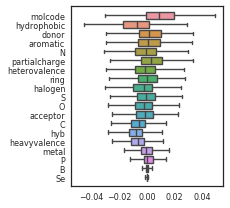

In [33]:
# plot range of weights, do not show outliers

fig, ax = plt.subplots(figsize=(3.3, 3))

sns.boxplot(data=w0, fliersize=0, orient='h', order=perc_diff.index, ax=ax)
ax.set_xlim(-0.055, 0.055)
ax.set_xticks(np.arange(-0.04, 0.05, 0.02))
ax.set_ylim(19, -1)

fig.tight_layout()

fig.savefig('%s/fi_box.pdf' % results_path)

# Find parts of input that are crucial for predicting activity

In [34]:
# select a single ligand, that was predicted to be active

ligand = '3ws8'
rotation = 2

ligand_idx = ids.index(ligand)
ligand_idx

19

In [35]:
ligand_grid = tfbio.data.make_grid(coords[ligand_idx], features[ligand_idx])
ligand_rot_grid = tfbio.data.make_grid(tfbio.data.rotate(coords[ligand_idx], rotation),
                                       features[ligand_idx])

for grid in (ligand_grid, ligand_rot_grid):
    grid[..., columns['partialcharge']] /= charge_std

## Baseline prediction

Check what is the baseline - prediction that our model returns, when we do not give him any inforation about the complex.
(We can think of it as an analogy to intercept in linear model.)

In [36]:
with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    zero_pred = session.run(y, feed_dict={x: np.zeros_like(ligand_grid), keep_prob: 1.0})

zero_pred

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


array([[ 3.72884059]], dtype=float32)

Make sure that our model did not learned to just recognize ligands or proteins and uses both ligand and protein to predict binding affinity.

In [37]:
no_lig = np.vstack((ligand_grid, ligand_rot_grid))
no_lig[no_lig[..., columns['molcode']] == 1.0] = 0.0


with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    no_lig_pred = session.run(y, feed_dict={x: no_lig, keep_prob: 1.0})

no_lig_pred

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


array([[ 3.62693   ],
       [ 3.67444158]], dtype=float32)

In [38]:
no_prot = np.vstack((ligand_grid, ligand_rot_grid))
no_prot[no_prot[..., columns['molcode']] == -1.0] = 0.0


with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    no_prot_pred = session.run(y, feed_dict={x: no_prot, keep_prob: 1.0})

no_prot_pred

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


array([[ 5.53257084],
       [ 5.52911186]], dtype=float32)

Interestingly, ligand with no protein gives higher predictions - this information is more important for the model.
We can also see in the weights' distribution, that weights associated with the `molcode` are more often positive.
This kind of filters recognizes ligand, while filters with strongly negative values recognize protein.

## Set parts of an input to 0

In [39]:
box = 5    # same size as in convolutional layers
step = 3
steps_in_loop = box_size // step

In [40]:
mean_pred = rot_predictions[rot_predictions['pdbid'] == ligand.upper()]['predicted'].mean()
mean_pred 

7.7010612

In [41]:
# prepare grids with a single deleted box in each

modified = np.repeat(ligand_grid, steps_in_loop**3, axis=0)
origins = []

num = 0
for i in range(0, box_size-step+1, step):
    for j in range(0, box_size-step+1, step):
        for k in range(0, box_size-step+1, step):
            origins.append((i, j, k))
            modified[num, i:i+box, j:j+box, k:k+box] = 0.0
            num += 1

assert num == steps_in_loop ** 3

origins = np.array(origins)

In [42]:
with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    modified_pred = session.run(y, feed_dict={x: modified, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


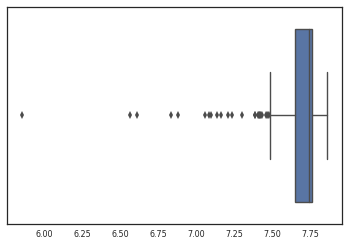

In [43]:
sns.boxplot(modified_pred);

In [44]:
# get 10 boxes with lowest predictions - those are ost important parts of an input

important_idx = np.argsort(modified_pred[:, 0])[:10]
important_idx

array([116, 115, 123, 171, 164, 172, 122, 170,  67, 165])

In [45]:
def get_box_atoms(indices, grid):
    """Get atoms from the grid that are in the boxes specified with indices"""
    
    important_atoms = []
    
    
    for idx in indices:
        i, j, k = origins[idx]

        tmp = grid[0][i:i+box, j:j+box, k:k+box]

        atom_table = pd.DataFrame(tmp[tmp[..., columns['molcode']] != 0],
                                  columns=featurizer.FEATURE_NAMES)
        atom_x, atom_y, atom_z = np.where(tmp[..., columns['molcode']] != 0)
        atom_x += i
        atom_y += j
        atom_z += k
        atom_table['x'] = atom_x
        atom_table['y'] = atom_y
        atom_table['z'] = atom_z
        atom_table['idx'] = idx
        important_atoms.append(atom_table)

    important_atoms = pd.concat(important_atoms, ignore_index=True)
    
    important_atoms['partialcharge'] *= charge_std
    
    return important_atoms

# columns we want to print
to_print = ['x', 'y', 'z', 'B', 'C', 'N', 'O', 'P', 'S', 'Se', 'hyb', 'partialcharge',
            'hydrophobic', 'aromatic', 'acceptor', 'donor', 'ring', 'idx']

In [46]:
def plot_boxes(complex_idx, rot, box_indices):
    """Plot molecular complex in the specified rotation and the boxes specified by indices"""
    

    from mpl_toolkits import mplot3d

    fig = plt.figure(figsize=(6, 6))

    crds = tfbio.data.rotate(coords[complex_idx], rot)
    ft = features[complex_idx]

    ax = fig.add_subplot(111, projection='3d')

    mx, my, mz = crds[ft[:, columns['molcode']] == 1.0].T + max_dist
    ax.scatter(mx, my, mz, label='ligand', c='b', s=20)

    mx, my, mz = crds[ft[:, columns['molcode']] == -1.0].T + max_dist
    ax.scatter(mx, my, mz, label='protein', c='g', s=5)

    for i, j, k in origins[box_indices]:
        alpha = 0.05
        ax.plot_surface([i, i+box], [[j, j], [j+box, j+box]], k, alpha=alpha, color='gray')
        ax.plot_surface([i, i+box], [[j, j], [j+box, j+box]], k+box, alpha=alpha, color='gray')
        ax.plot_surface(i, [[j, j], [j+box, j+box]], [k, k+box], alpha=alpha, color='gray')
        ax.plot_surface(i+box, [[j, j], [j+box, j+box]], [k, k+box], alpha=alpha, color='gray')
        ax.plot_surface([i, i+box], j, [k, k+box], alpha=alpha, color='gray')
        ax.plot_surface([i, i+box], j+box, [[k, k], [k+box, k+box]], alpha=alpha, color='gray')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.legend(loc=(0.75, 0.75), frameon=True)

    return fig, ax

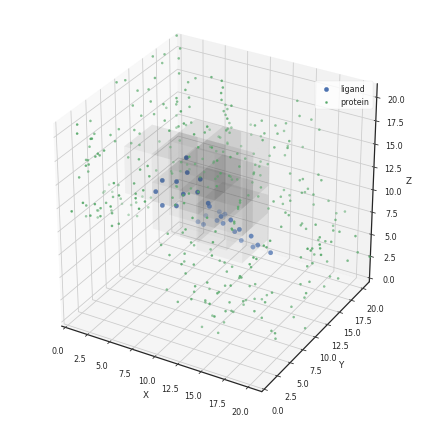

In [47]:
fig, ax = plot_boxes(ligand_idx, 0, important_idx)

ax.set_xlim(0, 21)
ax.set_ylim(0, 21)
ax.set_zlim(0, 21)

fig.tight_layout()
fig.savefig('%s/changes.pdf' % results_path);

In [48]:
important_atoms = get_box_atoms(important_idx, ligand_grid)

(important_atoms.loc[((important_atoms['molcode'] == -1.0)), to_print]
 .sort_values(['x', 'y', 'z'])
 .drop_duplicates(subset=['x', 'y', 'z']))

,x,y,z,B,C,N,O,P,S,Se,hyb,partialcharge,hydrophobic,aromatic,acceptor,donor,ring,idx
44,6,11,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1704,1.0,1.0,0.0,0.0,1.0,122
16,6,11,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1704,1.0,1.0,0.0,0.0,1.0,123
45,7,12,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1256,1.0,1.0,0.0,0.0,1.0,122
17,7,12,12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0118,1.0,1.0,0.0,0.0,1.0,123
18,7,12,13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1256,1.0,1.0,0.0,0.0,1.0,123
25,9,13,11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0343,1.0,0.0,0.0,0.0,0.0,171
40,12,10,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,-0.9407,0.0,0.0,1.0,1.0,0.0,172
41,12,11,15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.6951,0.0,0.0,0.0,0.0,0.0,172
42,12,12,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.6086,0.0,0.0,1.0,0.0,0.0,172
43,13,13,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0036,1.0,0.0,0.0,0.0,0.0,172


## Check what happens when we use different orientation

In [49]:
modified_rot = np.repeat(ligand_rot_grid, steps_in_loop**3, axis=0)

num = 0
for i in range(0, box_size-step+1, step):
    for j in range(0, box_size-step+1, step):
        for k in range(0, box_size-step+1, step):
            modified_rot[num, i:i+box, j:j+box, k:k+box] = 0.0
            num += 1

assert num == steps_in_loop**3

In [50]:
with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    modified_rot_pred = session.run(y, feed_dict={x: modified_rot, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


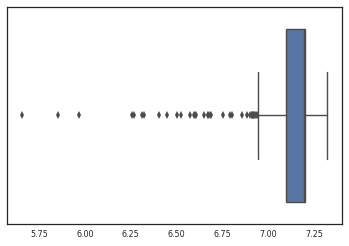

In [51]:
sns.boxplot(modified_rot_pred);

In [52]:
important_idx_rot = np.argsort(modified_rot_pred[:, 0])[:10]
important_idx_rot

array([121, 120, 164, 128, 170, 171,  72, 122, 165,  79])

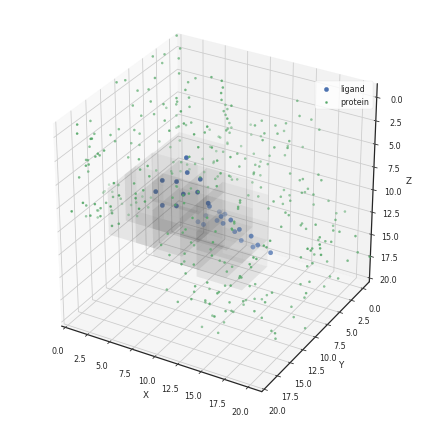

In [53]:
fig, ax = plot_boxes(ligand_idx, rotation, important_idx_rot)

ax.view_init(330, 60)
ax.set_xlim(0, 21)
ax.set_ylim(-1, 20)
ax.set_zlim(-1, 20)

fig.tight_layout()
fig.savefig('%s/changes_rot.pdf' % results_path);

In [54]:
important_atoms_rot = get_box_atoms(important_idx_rot, ligand_rot_grid)

(important_atoms_rot.loc[((important_atoms_rot['molcode'] == -1.0)), to_print]
 .sort_values(['x', 'y', 'z'])
 .drop_duplicates(subset=['x', 'y', 'z']))

,x,y,z,B,C,N,O,P,S,Se,hyb,partialcharge,hydrophobic,aromatic,acceptor,donor,ring,idx
61,5,9,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1072,1.0,1.0,0.0,0.0,1.0,72
0,6,9,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1704,1.0,1.0,0.0,0.0,1.0,121
1,6,9,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1704,1.0,1.0,0.0,0.0,1.0,121
21,9,7,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0343,1.0,0.0,0.0,0.0,0.0,164
40,9,15,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0660,1.0,0.0,0.0,0.0,0.0,128
41,9,16,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1072,1.0,1.0,0.0,0.0,1.0,128
53,10,13,12,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,-0.2737,1.0,0.0,1.0,0.0,0.0,171
42,10,15,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.1704,1.0,1.0,0.0,0.0,1.0,128
43,10,16,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0430,1.0,0.0,0.0,0.0,0.0,128
28,12,6,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.5679,0.0,0.0,1.0,0.0,0.0,164


## How the activations differ

In [55]:
with tf.Session(graph=graph) as session:
    saver.restore(session, './%s-best' % results_prefix)

    activations = session.run(hidden_layers, feed_dict={x: np.vstack((ligand_grid, ligand_rot_grid)),
                                                        keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ././results/batch5-2017-06-05T07:58:47-best


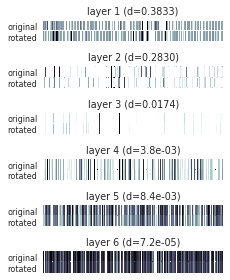

In [56]:
fig, axs = plt.subplots(nrows=len(hidden_layers), figsize=(3.3, 4))
axs = axs.flatten()

for i, ax in enumerate(axs):
    tmp = activations[i].reshape((2, -1))
    d = scipy.spatial.distance.pdist(tmp, metric='cos')
    vmin, vmax = np.percentile(tmp, [1, 99])
    sns.heatmap(tmp, xticklabels=False, yticklabels=['original', 'rotated'], vmin=vmin, vmax=vmax,
                cmap=plt.cm.bone_r, ax=ax, cbar=False);
    if d < 1e-2:
        ax.set_title('layer %i (d=%.1e)' % (i+1, d))
    else:
        ax.set_title('layer %i (d=%.4f)' % (i+1, d))
fig.tight_layout()

# save as PNG - each heatmap consists of thousands of tiny rectangles
fig.savefig('%s/activations.png' % results_path, dpi=300);